In [13]:
import pandas as pd
data = pd.read_csv('traffic.csv')
print(data.head())

              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041


In [19]:
data['DateTime'] = pd.to_datetime(data['DateTime'])
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB
None
           Junction      Vehicles            ID
count  48120.000000  48120.000000  4.812000e+04
mean       2.180549     22.791334  2.016330e+10
std        0.966955     20.750063  5.944854e+06
min        1.000000      1.000000  2.015110e+10
25%        1.000000      9.000000  2.016042e+10
50%        2.000000     15.000000  2.016093e+10
75%        3.000000     29.000000  2.017023e+10
max        4.000000    180.000000  2.017063e+10


In [20]:
data['day_of_week'] = data['DateTime'].dt.dayofweek
data['hour_of_day'] = data['DateTime'].dt.hour

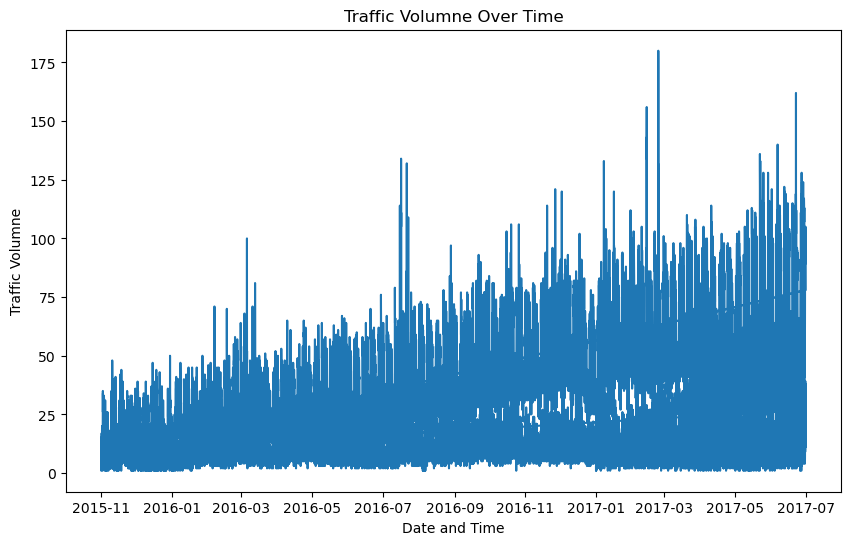

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(data['DateTime'], data['Vehicles'])
plt.title('Traffic Volumne Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Traffic Volumne')
plt.show()

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [45]:
junctions = data['Junction'].unique()[:1]
def train_sarima_model(junction_data):
    model = SARIMAX(junction_data['Vehicles'], order=(1,1,1), seasonal_order=(1,1,1,24))
    model_fit = model.fit(disp=False)
    return model_fit

In [46]:
def forecast_traffic(model, test_data):
    forecast = model.predict(start=test_data.index[0], end=test_data.index[-1])
    return forecast

C:\Users\Ayushi Patel\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Ayushi Patel\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


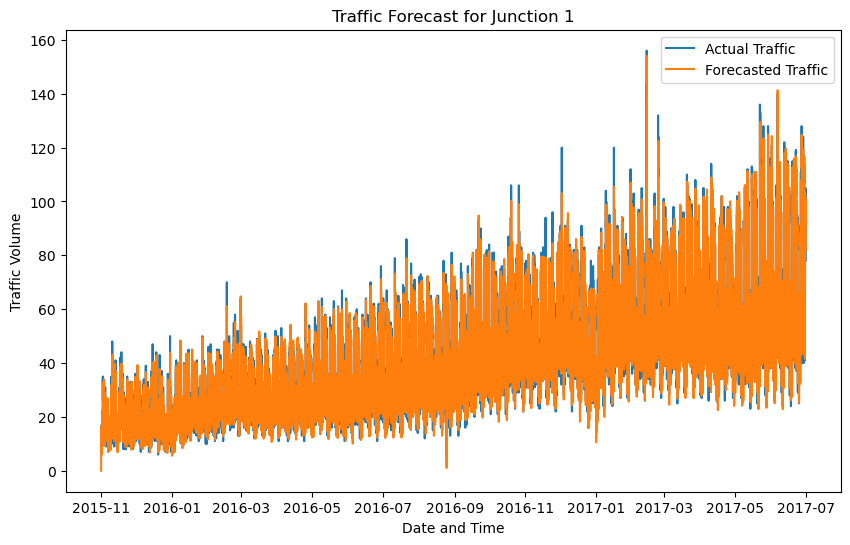

In [47]:
for Junction in junctions:
    junction_data = data[data['Junction'] == junction].set_index('DateTime')
    
    model = train_sarima_model(junction_data)
    
    forecast = forecast_traffic(model, junction_data)
    
    plt.figure(figsize=(10,6))
    plt.plot(junction_data.index, junction_data['Vehicles'], label='Actual Traffic')
    plt.plot(junction_data.index, forecast, label='Forecasted Traffic')
    plt.title(f'Traffic Forecast for Junction {junction}')
    plt.xlabel('Date and Time')
    plt.ylabel('Traffic Volume')
    plt.legend()
    plt.show()

In [51]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Function to perform cross-validation and calculate evaluation metrics
def cross_validate_sarimax(junction_data, n_splits=5):
    # Initialize time series splitter
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Initialize lists to store evaluation metrics
    mae_scores = []
    rmse_scores = []
    
    # Iterate over cross-validation folds
    for train_index, test_index in tscv.split(junction_data):
        # Split data into train and test sets
        train_data, test_data = junction_data.iloc[train_index], junction_data.iloc[test_index]
        
        # Train SARIMAX model
        model = train_sarima_model(train_data)
        
        # Forecast traffic
        forecast = forecast_traffic(model, test_data)
        
        # Calculate evaluation metrics
        mae = mean_absolute_error(test_data['Vehicles'], forecast)
        rmse = np.sqrt(mean_squared_error(test_data['Vehicles'], forecast))
        
        # Append scores to lists
        mae_scores.append(mae)
        rmse_scores.append(rmse)
    
    # Calculate mean scores
    mean_mae = np.mean(mae_scores)
    mean_rmse = np.mean(rmse_scores)
    
    return mean_mae, mean_rmse

# Iterate over each junction
for junction in junctions:
    junction_data = data[data['Junction'] == junction].set_index('DateTime')
    
    # Perform cross-validation and calculate evaluation metrics
    mean_mae, mean_rmse = cross_validate_sarimax(junction_data)
    
    # Print evaluation metrics
    print(f"Junction {junction}:")
    print(f"Mean Absolute Error (MAE): {mean_mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {mean_rmse:.2f}")
    print()


C:\Users\Ayushi Patel\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Ayushi Patel\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Ayushi Patel\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Ayushi Patel\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\Ayushi Patel\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

Junction 1:
Mean Absolute Error (MAE): 23.27
Root Mean Squared Error (RMSE): 26.85

